# Download Image Data from Bucket

In [2]:
import sys
sys.path.append('../src')

from data_utils import download_tiff_images, display_tiff

# Bucket and directory
bucket_name = 'tree-counting-project'
prefix = 'switzerland/'
local_dir = '../Data/Switzerland'

# Download images
download_tiff_images(bucket_name, prefix, local_dir)

Downloaded switzerland/Lens_image.tif to ../Data/Switzerland/Lens_image.tif
Downloaded switzerland/Lens_image_0.10.tif to ../Data/Switzerland/Lens_image_0.10.tif
Downloaded switzerland/Saxon_image.tif to ../Data/Switzerland/Saxon_image.tif
Downloaded switzerland/Saxon_image_0.10.tif to ../Data/Switzerland/Saxon_image_0.10.tif
Downloaded switzerland/Sierre_image.tif to ../Data/Switzerland/Sierre_image.tif
Downloaded switzerland/Sierre_image_0.10.tif to ../Data/Switzerland/Sierre_image_0.10.tif
Downloaded switzerland/Sion_image.tif to ../Data/Switzerland/Sion_image.tif
Downloaded switzerland/Sion_image_0.10.tif to ../Data/Switzerland/Sion_image_0.10.tif


# Diplay Image

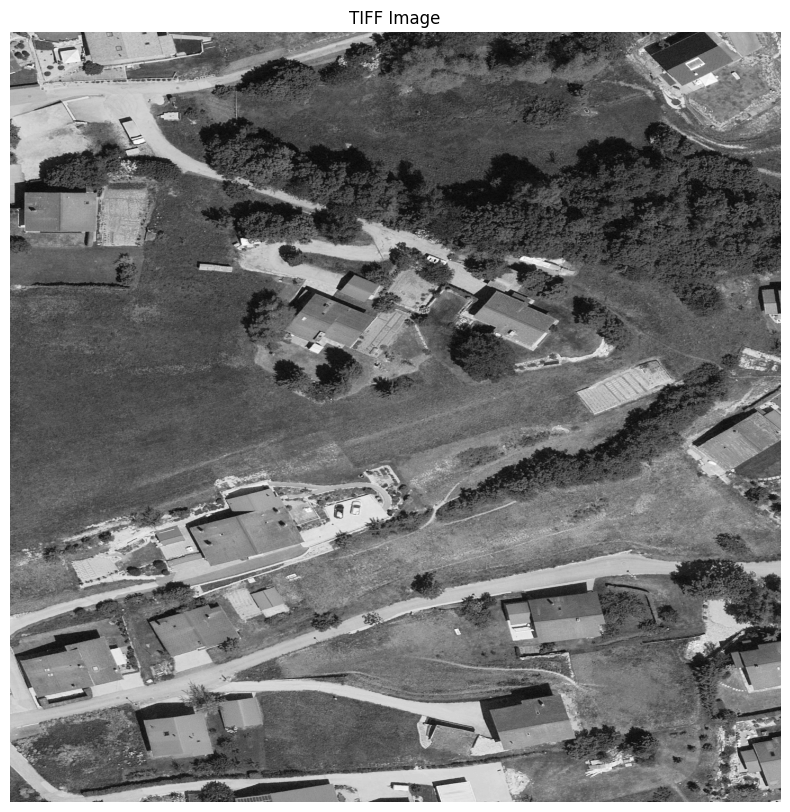

In [5]:
# Display an image
tiff_path = '../Data/Switzerland/Lens_image_0.10.tif'
display_tiff(tiff_path)


In [1]:
import ee
ee.Authenticate()

True

In [2]:
ee.Initialize()

In [8]:
import geemap

In [10]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
# https://viewer.nationalmap.gov/services/
url = "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}"
Map.add_tile_layer(url, name="Google Satellite", attribution="Google")